<a href="https://colab.research.google.com/github/mmsamiei/MS-Thesis-Phase3/blob/master/Models/Montazeri/Montazeri_L-12-6_H-128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In the name of God

In [1]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-connect-button").click() 
  }
  var connect_timer = setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [2]:
!nvidia-smi

Thu Jul  9 17:29:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip -q install transformers

     |████████████████████████████████| 778kB 14.1MB/s 
     |████████████████████████████████| 3.0MB 56.7MB/s 
     |████████████████████████████████| 1.1MB 45.9MB/s 
     |████████████████████████████████| 890kB 54.1MB/s 


In [5]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
import json
from torch.utils.data.sampler import SubsetRandomSampler
from transformers import AutoTokenizer
import random
import pandas as pd
import logging
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoModel

# Dataset

In [6]:
train_file = '/content/drive/My Drive/Thesis/phase-3/hkr_train.csv'
valid_file =  '/content/drive/My Drive/Thesis/phase-3/hkr_valid.csv'
test_seen_file = '/content/drive/My Drive/Thesis/phase-3/hkr_test_seen.csv'
test_unseen_file = '/content/drive/My Drive/Thesis/phase-3/hkr_test_unseen.csv'
last_sentence_file = '/content/drive/My Drive/Thesis/phase-3/last_sentence.csv'
squad_file = '/content/drive/My Drive/Thesis/phase-3/squad.csv'

In [7]:
enc_tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-12_H-128_A-2')
dec_tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-6_H-128_A-2')

In [8]:
class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, csv_file, frac=1, split_rate=1, max_len=512, sort=True, bound=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.dialogues = pd.read_csv(csv_file)
        #self.dialogues.dropna(inplace=True)
        
        self.dialogues.fillna("", inplace=True)
        self.dialogues = self.dialogues[self.dialogues.index % split_rate == 0]

        #self.dialogues = self.dialogues.sample(frac=frac)
        
        if bound:
          len_prt = int(len(self.dialogues) / 5)
          self.dialogues = self.dialogues[ : len_prt]

        s = self.dialogues['response'].apply(dec_tokenizer.encode).apply(len).sort_values().index
        self.dialogues = self.dialogues.reindex(s)

        

        #self.dialogues.dropna(inplace=True)

        self.max_len = max_len


    def __len__(self):
        return len(self.dialogues)

    @staticmethod
    def truncuate_join_pair_sentence(sentence1, sentence2, max_len=510):

        """
        truncuate sentence one from head and sentence two from tail
        Args:
            sentence1 (string): first sentence
            sentence2 (string): seconde sentence
        """
        temp1 = enc_tokenizer.encode(sentence1,add_special_tokens=False)
        temp2 = enc_tokenizer.encode(sentence2,add_special_tokens=False)
        ### two above line may cause warning but no problem because we've handle them below
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
        seq_1 = temp1
        seq_2 = temp2
        num_tokens_to_remove = len(temp1) + len(temp2) + 3 - max_len
        if num_tokens_to_remove > 0 :
            seq_1, seq_2, _ = enc_tokenizer.truncate_sequences(temp1[::-1],temp2, num_tokens_to_remove=num_tokens_to_remove,
                                                               truncation_strategy='longest_first')
            seq_1.reverse()
        result_list = [enc_tokenizer.cls_token_id]+seq_1+[enc_tokenizer.sep_token_id]+seq_2+[enc_tokenizer.sep_token_id]
        token_type_ids = [0] * (len(seq_1) + 2) + [1] * (len(seq_2) + 1)
        return result_list, token_type_ids


    def __getitem__(self, idx):
      
        
        history = self.dialogues.iloc[idx].history
        knowledge = self.dialogues.iloc[idx].knowledge
        response = self.dialogues.iloc[idx].response


        input_pair, input_pair_segments = MyDataset.truncuate_join_pair_sentence(history, knowledge, self.max_len)
                

        input_pair = torch.LongTensor(input_pair)

        input_pair_segments = torch.LongTensor(input_pair_segments)

        response_tensor = torch.LongTensor(dec_tokenizer.encode(response, truncation=True, max_length=128))

        sample = {'input_pair': input_pair,
                  'input_pair_segments': input_pair_segments,
                  'response': response_tensor}

        return sample


In [9]:
train_dataset = MyDataset(train_file, max_len=128, bound=False)
valid_dataset = MyDataset(valid_file, max_len=128)
test_unseen_dataset = MyDataset(test_unseen_file, max_len=512)
print(len(test_unseen_dataset))
print(len(train_dataset))
print(len(valid_dataset))

2075
41489
4458


In [10]:
print(enc_tokenizer.decode(train_dataset[200]['input_pair']))
print(dec_tokenizer.decode(train_dataset[200]['response']))

[CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
[CLS] 2007 in walnut creek california [SEP]


In [12]:
from tqdm.auto import tqdm

def my_collate_fn(batch):

  len_batch = len(batch)

  
  max_len_input_pair = max([len(data['input_pair']) for data in batch])

  max_len_response = max([len(data['response']) for data in batch])
  
  padding_ind = 0 ## for bert is 0 DON'T THINK BAD IT IS NOT REFACTORING !!!!!!
  result_input_pair = torch.zeros(len_batch, max_len_input_pair)
  result_input_pair_segments = torch.zeros(len_batch, max_len_input_pair)
  result_response = torch.zeros(len_batch, max_len_response)

  for i, data in enumerate(batch):
    p1 = len(data['input_pair'])
    result_input_pair[i, :p1] = data['input_pair']

    p3 = len(data['input_pair_segments'])
    result_input_pair_segments[i, :p3] = data['input_pair_segments']

    p4 = len(data['response'])
    result_response[i, :p4] = data['response']

  return result_input_pair.long(), result_input_pair_segments.long(), result_response.long()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                             shuffle=True, collate_fn=my_collate_fn,
                                           num_workers=1)

#valid_sampler = torch.utils.data.SequentialSampler(valid_dataset)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64,
                                             shuffle=False, collate_fn=my_collate_fn, num_workers=1)


i = 0 
for batch_idx, batch  in tqdm(enumerate(train_loader)):
  pair_batch, segment_batch, response_batch = batch
  print(pair_batch.shape)
  print(segment_batch.shape)
  print(response_batch.shape)
  print("****")
  i += 1 
  if(i==2):
    break

print(len(train_loader))
print(len(valid_loader))

torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 61])
****
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 56])
****
649
70


In [ ]:
o = torch.rand(8,5)
o

tensor([[0.7971, 0.5570, 0.6176, 0.8620, 0.0346],
        [0.2617, 0.9808, 0.7682, 0.6243, 0.2782],
        [0.4833, 0.6336, 0.0463, 0.0938, 0.4098],
        [0.9999, 0.7067, 0.1404, 0.7106, 0.1492],
        [0.0357, 0.5070, 0.1811, 0.8164, 0.6623],
        [0.6191, 0.1194, 0.4503, 0.9537, 0.8837],
        [0.2407, 0.3513, 0.4584, 0.2995, 0.2904],
        [0.1673, 0.0891, 0.2090, 0.0751, 0.6567]])

In [ ]:
y = torch.LongTensor(8).random_(0,5)
y

tensor([2, 0, 0, 0, 4, 1, 4, 2])

In [ ]:
o[y!=2]

tensor([[0.2617, 0.9808, 0.7682, 0.6243, 0.2782],
        [0.4833, 0.6336, 0.0463, 0.0938, 0.4098],
        [0.9999, 0.7067, 0.1404, 0.7106, 0.1492],
        [0.0357, 0.5070, 0.1811, 0.8164, 0.6623],
        [0.6191, 0.1194, 0.4503, 0.9537, 0.8837],
        [0.2407, 0.3513, 0.4584, 0.2995, 0.2904]])

In [ ]:
z = torch.LongTensor(o[y!=2].shape[0]).fill_(2)
z

tensor([2, 2, 2, 2, 2, 2])

In [ ]:
torch.

In [ ]:
-1*F.nll_loss(nn.functional.log_softmax(o[y!=2]), z, reduction='mean')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor(-1.7754)

# Model

In [13]:
from transformers import EncoderDecoderModel, BertTokenizer

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.seq2seq = EncoderDecoderModel.from_encoder_decoder_pretrained(
        'google/bert_uncased_L-12_H-128_A-2', 'google/bert_uncased_L-6_H-128_A-2')
    
    # for p in self.seq2seq.encoder.embeddings.parameters():
    #    p.requires_grad = False
    
    # for p in self.seq2seq.decoder.bert.embeddings.parameters():
    #    p.requires_grad = False

  def forward(self, encoder_input, segments_tensors, decoder_input):
    '''
    encoder_input = [batch_size, enc_len]
    segments_tensors = [batch_size, enc_len]
    decoder_input = [batch_size, dec_len]
    '''
    kwargs = {'token_type_ids':segments_tensors}
    kwargs = {}
    outputs = self.seq2seq(input_ids=encoder_input, decoder_input_ids=decoder_input, **kwargs)[0]
    return outputs
  
  def generate(self, encoder_input, segments_tensors, **kwargs):
    ### encoder_input = [len] in int format
    ### segment_tensors = [len]
    encoder_input = encoder_input.unsqueeze(0)
    segments_tensors = segments_tensors.unsqueeze(0)
    
    model_specific_kwargs = {}
    #model_specific_kwargs['token_type_ids'] = {'token_type_ids':segments_tensors}

    generated = model.seq2seq.generate(encoder_input, decoder_start_token_id=101,
                                       eos_token_id=102, ## [SEP] = 102
                                       **kwargs, **model_specific_kwargs)

    #### generated = [1, len]
    return generated

In [14]:
dev = torch.device('cuda')
model = Model().to(dev)

# x = torch.LongTensor(200, 40).random_(1,1000).to(dev)
# print(model(x).shape)


def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

Some weights of the model checkpoint at google/bert_uncased_L-6_H-128_A-2 were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at google/bert_uncased_L-6_H-128_A-2 and are newly initialized: ['bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.sel

11992762


#Optimizer



In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [16]:
from transformers import get_cosine_schedule_with_warmup, get_constant_schedule
scheduler = get_constant_schedule(optimizer)

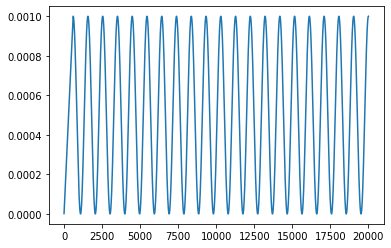

In [ ]:
lrs = []
for i in tqdm(range(20000)):
  optimizer.step()
  scheduler.step()
  lrs.append(scheduler.get_last_lr()[0])
import matplotlib.pyplot as plt
plt.plot(lrs)

# Training

In [17]:
df = pd.read_csv(train_file)
freqs = [1] * dec_tokenizer.vocab_size
for response in tqdm(df['response']):
  tknzd = dec_tokenizer.encode(response)
  for tkn in tknzd:
    freqs[tkn] += 1

In [18]:
def get_weights(_lambda = 0):
  weights = torch.ones(dec_tokenizer.vocab_size)
  for idx, freq in enumerate(freqs):
    weight = 1 / (freq**_lambda)
    weights[idx] = weight
  return weights

In [19]:
import torch.nn

weight = get_weights().to(dev)

def mahdi_loss(model_output, true_trg, **kwargs):
  '''
  model_output: [batch, len, hidden]
  true_trg: [batch, len]
  '''
  model_output = model_output[:,:-1,:]
  true_trg = true_trg[:,1:]

  # cold
  #T = 1
  #model_output = model_output / T

  if 'easy_training' in kwargs:
    print("Easy training")
    limit_last_tokens = kwargs['easy_training']
    model_output = model_output[:,-limit_last_tokens:,:]
    true_trg = true_trg[:,-limit_last_tokens:]

  batch_len = model_output.shape[0]
  snt_len = model_output.shape[1]
  hidden_size = model_output.shape[2]

  model_output = model_output.reshape(-1, hidden_size)
  true_trg = true_trg.reshape(-1)

  loss_mod = nn.CrossEntropyLoss(weight=weight, ignore_index=0)## PAD = 0
  loss = loss_mod(model_output, true_trg)



  #z = torch.LongTensor(model_output[true_trg!=1045].shape[0]).fill_(1045).to(dev)
  #neg_loss = -0.5*F.nll_loss(nn.functional.log_softmax(model_output[true_trg!=1045]), z, reduction='mean')

  return loss 

In [22]:
from tqdm.auto import tqdm

def train_step(batch_idx, batch):
  pair_batch, segment_batch, response_batch = batch
  pair_batch = pair_batch.to(dev)
  segment_batch = segment_batch.to(dev)
  response_batch = response_batch.to(dev)
  model_output = model(pair_batch, segment_batch, response_batch)
  #kwargs = {'easy_training':4}
  loss = mahdi_loss(model_output, response_batch)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  scheduler.step()
  del pair_batch
  del segment_batch
  del response_batch
  return loss.item()

def valid_step(batch_idx, batch):
  with torch.no_grad():
    pair_batch, segment_batch, response_batch = batch
    pair_batch = pair_batch.to(dev)
    segment_batch = segment_batch.to(dev)
    response_batch = response_batch.to(dev)
    model_output = model(pair_batch, segment_batch, response_batch)
    loss = mahdi_loss(model_output, response_batch)
    del pair_batch
    del segment_batch
    del response_batch
    return loss.item()

def valid_loop(valid_loader):
  total_loss = 0
  model.eval()
  for batch_idx, batch in tqdm(enumerate(valid_loader),  total=len(valid_loader), leave=False):
    total_loss += valid_step(batch_idx, batch)
  
  print("temperature is 1:")
  kwargs = {'num_beams':16,'num_return_sequences':8,'temperature':1,
            'no_repeat_ngram_size':3}
  valid_inference(**kwargs)

  print("most greedy sentence:")
  kwargs = {
          'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
          'no_repeat_ngram_size':3,
          'top-k':1
          }
  valid_inference(**kwargs)

  # print("temperature is 2:")
  # kwargs = {'num_beams':16,'num_return_sequences':16,'temperature':2}
  # valid_inference(**kwargs)


  model.train()
  return total_loss / len(valid_loader)

def valid_inference(idx=200, **kwargs):
  hk_pair =  train_dataset[idx]['input_pair'].to(dev)
  hk_segment = train_dataset[idx]['input_pair_segments'].to(dev)
  response = train_dataset[idx]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  print("pair is: ",enc_tokenizer.decode(hk_pair))
  print("response is: ",dec_tokenizer.decode(response))
  for generated in generateds:
    print("model says: ",dec_tokenizer.decode(generated))

In [23]:
new_learning = True
if new_learning:
  # optimizer = NoamOpt(128, 1, 2000,
  #           torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Montazeri/L-12-6_H-128/"
  step = 0
  log_list = []

In [ ]:
## if continue learning:
#!wget -q https://github.com/mmsamiei/MS-Thesis-Phase2/raw/master/Models/hashemi_16000steps.model
model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Montazeri/L-6-12_H-128"
checkpoint = torch.load(model_dir+'/montazeri_18000steps.model')
step = checkpoint['log_list'][-1]['step']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer._step = step
log_list = checkpoint['log_list']
new_learning = False
print(step)

18000


In [24]:
from tqdm.auto import tqdm

MAX_STEP = 20000
STEP_SAVE = 500
STEP_CHECK = 500
step_num = step + 1
log_list = log_list ### Check if new learning or not
print(step_num)
while step_num <= MAX_STEP:
  model.train()
  for batch_idx, batch in tqdm(enumerate(iter(train_loader)), total=len(train_loader), leave=False):
    step_loss = train_step(batch_idx, batch)
    log = {'step':step_num, 'train_loss':step_loss}

    if(step_num % STEP_CHECK == 0):
      valid_error = valid_loop(valid_loader)
      train_losses = [step['train_loss'] for step in log_list[-100:]]
      avg_train_loss = sum(train_losses) / len(train_losses)
      print("train Loss rate: {} at step {}".format(avg_train_loss, step_num))  
      print("valid Loss rate: {} at step {}".format(valid_error, step_num))  
      log['valid_loss'] = valid_error

    log_list.append(log)

    if(step_num % STEP_SAVE == 0):
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
            }, model_dir+'montazeri_{}steps.model'.format(step_num))
    step_num += 1

1


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] i don't know it's one of the most popular bands in the united states.
model says:  [CLS] i don't know it's one of the most popular bands. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i don't know it's one of the most popular in the united states. [SEP]
model says:  [CLS] i don't know it's one of the most popular bands in the us. [SEP]
model says:  [CLS] i don't know it's one of the most popular bands in the united states,
model says:  [

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] i don't know that they were formed in the united states. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i don't know that they were formed in the united states. it's a big
model says:  [CLS] i don't know that they were formed in the united states. it's formed in
model says:  [CLS] i don't know that they were formed in the united states in the us. [SEP] [SEP]
model says:  [CLS] i don't know that they were formed in the united states.

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] i'm not sure. it's one of the most popular bands in the united states
model says:  [CLS] i'm not sure. it's one of the most popular bands in the us.
model says:  [CLS] i'm not sure, but it's one of the most popular bands in the us
model says:  [CLS] i'm not sure, but it's one of the most popular bands in the united
model says:  [CLS] i'm not sure. it's one of the most popular ones in the united states
model says:  [CLS] i'm not sure, 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] i'm not sure, but i don't know it's a big fan of
model says:  [CLS] i'm not sure, but i don't think it's a big fan of
model says:  [CLS] i'm not sure, but i don't believe they were formed in the united states
model says:  [CLS] i'm not sure, but i don't know that the band was formed in 1981
model says:  [CLS] i'm not sure, but i don't know that the band was formed in 1991
model says:  [CLS] i'm not sure, but i don't know that the band

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] i'm not sure, but it's one of the most popular bands in the us
model says:  [CLS] i'm not sure, but it's one of the most popular bands in the united
model says:  [CLS] i'm not sure, but it's a big fan of the rolling stones. [SEP]
model says:  [CLS] i'm not sure, but it's one of the biggest bands in the us.
model says:  [CLS] i'm not sure, but it's a huge fan of the rolling stones. [SEP]
model says:  [CLS] i'm not sure, but it's a big 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] i'm not sure, but it's one of the most popular bands in the us
model says:  [CLS] i'm not sure, but it's one of the biggest bands in the us.
model says:  [CLS] i'm not sure, but it's one of the most popular bands in the united
model says:  [CLS] i'm not sure, but it's one of the largest bands in the us.
model says:  [CLS] i'm not sure, but it's a big fan of the punk rock band.
model says:  [CLS] i'm not sure, but it's one of the bigge

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] i'm not sure, but it's one of the most popular bands in the us
model says:  [CLS] i'm not sure, but it's a big fan of the punk rock band.
model says:  [CLS] i'm not sure, but it's one of the most popular bands in the united
model says:  [CLS] i'm not sure, but it's one of the biggest bands in the us.
model says:  [CLS] i'm not sure, but it's a huge fan of the punk rock band.
model says:  [CLS] i'm not sure, but it's a huge fan of the 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] i'm not sure, but they were formed in walnut creek in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure. they were formed in walnut creek in 2007. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but they were formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure but they were formed in walnut creek in 2007. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but it's a big fan of the p

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] i'm not sure, but they were formed in walnut creek in 2007. [SEP]
model says:  [CLS] they were formed in walnut creek in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure but they were formed in walnut creek in 2007. [SEP] [SEP]
model says:  [CLS] i'm not sure. they were formed in walnut creek in 2007. [SEP] [SEP]
model says:  [CLS] i'm not sure, but they were formed in 2007. [SEP] [SEP] [SEP] [SEP]

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they were formed in walnut creek in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but they were formed in walnut creek in 2007. [SEP]
model says:  [CLS] they were formed in 2007 in walnut creek, california. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but they

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they were formed in walnut creek in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure but they were formed in walnut creek in 2007. [SEP]
model says:  [CLS] they were formed in 2007 in walnut creek, california. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure but they were formed in 2007. [

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they were formed in walnut creek in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure but they were formed in walnut creek in 2007. [SEP] [SEP]
model says:  [CLS] i'm not sure, but they were formed in walnut creek in 2007. [SEP]
model says:  [CLS] i'm not sure, but they were formed in 2007. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure but they were formed in 2007. [SEP] [SEP] [SEP] [SEP] 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they were formed in walnut creek in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek in 2007. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in 2007 in walnut creek, california. [SEP]
model says:  [CLS] they are formed in walnut creek in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in walnut creek, calif

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they were formed in walnut creek in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek in 2007. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] yes, they were formed in walnut creek in 2007. [SEP]
model says:  [CLS] they were formed in 2007 in walnut creek, california. [SEP]
model says:  [CLS] they were formed in walnut creek, california 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they formed in walnut creek in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in walnut creek in 2007. [SEP] [SEP]
model says:  [CLS] they were formed in walnut creek, california. [SEP] [SEP]
model says:  [CLS] yea they formed in walnut creek in 2007. [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california in 2007. [SEP]
model says:  [C

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they were formed in walnut creek in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek in 2007. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they are formed in walnut creek in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] it was formed in walnut creek in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they are formed in walnut creek, californi

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they were formed in walnut creek in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek in 2007. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they are formed in walnut creek in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in 2007 in walnut creek, california. [SEP]
model says:  [CLS] they were formed in walnut creek, calif

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they were formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in walnut creek in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] they are formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in walnut creek, california, california. [SEP]
model says:  [CLS] they were formed in 2007 in walnut creek, california. [SEP]
model says:  [CLS] they formed in walnut creek in 2

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they formed in walnut creek in 2007. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in 2007 in walnut creek, california. [SEP] [SEP]
model says:  [CLS] they 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they formed in walnut creek in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california. [SEP]
model says:  [CLS] they are formed in walnut creek, california. [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california in 2007. [SEP]
model says:  [CLS] they formed in walnut creek, california, california. [SEP]
mod

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek in 2007. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california, california. [SEP] [SEP] [SEP]
model says:  [CLS] they are formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california, california. [SEP]
model says:  [CLS] they formed in walnut creek, california, california. [SEP] [SEP] [SEP]
model says:  [CLS]

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california, california. [SEP]
model says:  [CLS] the story was formed in 2007. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they are formed in walnut creek, california. [SEP] [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california. [SEP]
mode

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they are formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they are formed in walnut creek, california, california. [SEP]
model says:  [CLS] they formed in walnut creek, california, california. [SEP] [SEP]
model says:  [CLS] they were formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they are from walnut cree

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they are formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california, california. [SEP] [SEP]
model says:  [CLS] they were formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they are formed in walnu

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they are formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california, california. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they are formed in walnut creek, california, california. [SEP] [SEP]
model says:  [C

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they are from walnut creek, california. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california, california. [SEP]
model says:  [CLS] they formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] th

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they were formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] the story was formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california, california. [SEP]
model says:  [CLS] yea th

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california, california. [SEP]
model says:  [CLS] yea they formed in walnut creek, california. [SEP]
model says:  [CLS] they are formed in walnut creek, california. [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california in 2007. [SEP]
model says:  [CLS] they were formed in walnut creek, california. [SEP] [SEP]
mode

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they were formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in 2007 in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yea they were formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yea they formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP]
model sa

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they were formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they are formed in walnut creek, california. [SEP] [SEP]
model says:  [CLS] the story was formed in 2007. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yea they were formed in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says: 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they were formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] yea they formed in walnut creek, california. [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yea they were formed in walnut creek, california. [SEP]
model says:  [CLS] the story was formed in walnut creek, california. [SEP] [SEP]
model says:  [CLS] they are formed in walnut creek, califo

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in 2007 in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california, california. [SEP] [SEP]
model says:  [CLS] they were formed in 2007 in walnut creek, california, california. [SEP

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] yea they formed in walnut creek, california. [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they are formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] yea they are formed in walnut creek, california. [SEP]
model says:  [CLS] they were formed in 2007. [SEP] [SEP] [

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yea they formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california, california. [SEP] [SEP] [SEP]
model says:  [CLS] 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in 2007 in walnut creek, california. [SEP] [SEP]
model says:  [CLS] they were formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california, california. [SEP]
model says:  [CLS] they f

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in 2007 in walnut creek, california. [SEP]
model says:  [CLS] they were formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california. [SEP] [SEP]
model says:  [CLS] they are formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] yea they formed in walnut creek,

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in 2007 in walnut creek, california. [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yea they formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] the stor

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yea they formed in walnut creek, california. [SEP] [SEP]
model says:  [CLS] they are formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california. [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california in 2007. [SEP] [SEP]
model says:  [CLS] they were formed in walnut creek, ca

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they formed in walnut creek, california. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yea they formed in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in 2007 in walnut creek, california. [SEP] [SEP] [SEP]
model says:  [CLS] they formed in walnut creek, california in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] they were formed in 2007 in walnut creek, california. [SEP] [SEP]
model says:  [CLS] they are 

In [ ]:
kwargs = {'num_beams':64,
          'num_return_sequences':64,'temperature':1, 'max_length':50, 'early_stopping':True,
          'no_repeat_ngram_size':1,
          #'top-k':1
          }
valid_inference(idx=120, **kwargs)

pair is:  [CLS] bbc [SEP] hi, i hope you are doing well. i would like to talk about the bbc and its programs. do you watch any bbc programs? [SEP] no but ive seen them before [SEP] the bbc was established by the royal charter [SEP] oh really when was that [SEP] the bbc is established under a royal charter and operates under its agreement with the secretary of state for culture, media and sport. [SEP]
response is:  [CLS] it was established in 1957 [SEP]
model says:  [CLS] yes, it was established under the royal charter. [SEP] [SEP] [SEP]
model says:  [CLS] yes, bbc was established under the royal charter. [SEP] [SEP] [SEP]
model says:  [CLS] it was established under the royal charter. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] it is established under the royal charter [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yea it was established under the royal charter [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, bbc was established under the royal charter [SEP] [SEP] [SEP] [SEP

In [ ]:
dec_tokenizer.encode("they")

[101, 2027, 102]

In [ ]:
log_list[-100:]

[{'step': 20020, 'train_loss': 2.707136392593384},
 {'step': 20021, 'train_loss': 2.666339159011841},
 {'step': 20022, 'train_loss': 2.607372999191284},
 {'step': 20023, 'train_loss': 2.6693050861358643},
 {'step': 20024, 'train_loss': 2.6995174884796143},
 {'step': 20025, 'train_loss': 2.7086617946624756},
 {'step': 20026, 'train_loss': 2.710463523864746},
 {'step': 20027, 'train_loss': 2.6958489418029785},
 {'step': 20028, 'train_loss': 2.58896803855896},
 {'step': 20029, 'train_loss': 2.635009765625},
 {'step': 20030, 'train_loss': 2.790410280227661},
 {'step': 20031, 'train_loss': 2.630126476287842},
 {'step': 20032, 'train_loss': 2.6290857791900635},
 {'step': 20033, 'train_loss': 2.5103588104248047},
 {'step': 20034, 'train_loss': 2.5996921062469482},
 {'step': 20035, 'train_loss': 2.6798832416534424},
 {'step': 20036, 'train_loss': 2.7864038944244385},
 {'step': 20037, 'train_loss': 2.678417682647705},
 {'step': 20038, 'train_loss': 2.6533751487731934},
 {'step': 20039, 'train_l

In [ ]:
import numpy as np
logging.getLogger("transformers").setLevel(logging.ERROR)

f_scores = []
for i in tqdm(range(len(test_seen_dataset))):
  kwargs = {'num_beams':4,
            'num_return_sequences':1,'temperature':1, 'max_length':50, 'early_stopping':True,
            'no_repeat_ngram_size':1,
            #'top-k':1
            }
  idx = 100
  hk_pair =  test_seen_dataset[idx]['input_pair'].to(dev)
  hk_segment = test_seen_dataset[idx]['input_pair_segments'].to(dev)
  response = test_seen_dataset[idx]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  generateds = generateds.squeeze(0).cpu().numpy()
  response = response.squeeze(0).cpu().numpy()
  intersections = np.intersect1d(generateds, response)
  recall = len(intersections) / len(response)
  precision = len(intersections) / len(generateds)
  f1_score = 2 * (precision * recall) / (precision + recall)
  f_scores.append(f1_score)
  if(i % 100 == 0):
    print( sum(f_scores) / len(f_scores))

print( sum(f_scores) / len(f_scores))

0.2727272727272727
0.28680508288228934


KeyboardInterrupt: ignored

In [ ]:
valid_loop(test_seen_loader)

temperature is 1:
pair is:  [CLS] the story so far ( band ) [SEP] the story so far is an american band, heard of them? [SEP] no i have not! tell me about them, what genre of music to they create? [SEP] they are american pop punk band from california [SEP] oh i see thats awesome, hvae you ever seen them live? [SEP] no but they have released three albums so far [SEP] i see, when were they formed? [SEP] the story so far is an american pop punk band from walnut creek, california, formed in 2007. [SEP]
response is:  [CLS] 2007 in walnut creek california [SEP]
model says:  [CLS] they were formed in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] yea they were formed in 2007. [SEP]
model says:  [CLS] they were formed in 2007 [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yea they were formed in 2007 [SEP] [SEP]
model says:  [CLS] they are formed in 2007. [SEP] [SEP] [SEP]
model says:  [CLS] yea they formed in 2007. [SEP] [SEP]
model says:  [CLS] they formed in 2007. [SEP] [SEP] [SEP] [SEP]
model says:

3.1583475862230572